In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import math
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import svm
from matplotlib import style
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve
style.use("ggplot")
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# FUNCTIONS
#reads in all the sample names used as keys in the dictionary
def getFileNames(file, exp):
    samples_list = []
    inFile = open(file, 'r')
    for line in inFile:
        splitLine=line.strip().split('\n')
        name=splitLine[0]
        if exp in name:
            samples_list.append(name)
#         elif exp not in name:
#             print(name)
    inFile.close()
    return samples_list
    
#normalizes for sequencing depth CPM counts per million and for enhancer length KB (kilobase)
def normalize_CPKM(exp_dict):
    for name, counts in exp_dict.items():
        count_per_enhancer = [x[0] for x in counts]
        total_counts_per_sample = sum(count_per_enhancer)
        cpkm_vals = [(tup[0] / (tup[1] * total_counts_per_sample)) * 10**9 for tup in counts]
        exp_dict[name] = cpkm_vals


def run_ds_on_exp(samples_dir, rel_path, exp):
    sampleDict = {}
    samples = getFileNames(samples_dir, exp)
    for sample in samples:
        cts_counts_wlength(rel_path, sample, sampleDict)
    
    #rename dictionary keys to specify conditions and replicates         
    rename_keys(sampleDict)

    #normalize the data using CPKM
    normDict = norm(sampleDict, exp)

    return normDict

def rename(sampleDict, r1, r2, condition):
    #dictionary[new_key] = dictionary.pop(old_key)
    #https://stackoverflow.com/questions/4406501/change-the-name-of-a-key-in-dictionary
    sampleDict['En_'+condition+'_r1'] = sampleDict.pop(r1+'_end')
    sampleDict['Fb_'+condition+'_r1'] = sampleDict.pop(r1+'_fib')
    sampleDict['My_'+condition+'_r1'] = sampleDict.pop(r1+'_mye')

    sampleDict['En_'+condition+'_r2'] = sampleDict.pop(r2+'_end')
    sampleDict['Fb_'+condition+'_r2'] = sampleDict.pop(r2+'_fib')
    sampleDict['My_'+condition+'_r2'] = sampleDict.pop(r2+'_mye')

def rename_keys(sampleDict):
    rename(sampleDict, 'Sample1', 'Sample2', 'Sham')
    rename(sampleDict, 'Sample3', 'Sample4', 'TAC')
    rename(sampleDict, 'Sample5', 'Sample6', 'JQ1W')
    rename(sampleDict, 'Sample7', 'Sample8', 'JQ1')
        
def combine(sampleDict, cellType, condition):
    combined = []
    for s1,s2 in zip(sampleDict[cellType+'_'+condition+'_r1'],sampleDict[cellType+'_'+condition+'_r2']):
        combined.append(s1+s2)
    return combined

#combine replicate cpkm values        
def combine_replicates_cpkm(sampleDict, exp):
    replicateDict = {}  
    replicateDict[exp +'_Endo_Sham'] = combine(sampleDict, 'En', 'Sham')
    replicateDict[exp +'_Fb_Sham'] = combine(sampleDict, 'Fb', 'Sham')
    replicateDict[exp +'_Mye_Sham'] = combine(sampleDict, 'My', 'Sham')
    
    replicateDict[exp +'_Endo_TAC'] = combine(sampleDict, 'En', 'TAC')
    replicateDict[exp +'_Fb_TAC'] = combine(sampleDict, 'Fb', 'TAC')
    replicateDict[exp +'_Mye_TAC'] = combine(sampleDict, 'My', 'TAC')
    
    replicateDict[exp +'_Endo_JQ1W'] = combine(sampleDict, 'En', 'JQ1W')
    replicateDict[exp +'_Fb_JQ1W'] = combine(sampleDict, 'Fb', 'JQ1W')
    replicateDict[exp +'_Mye_JQ1W'] = combine(sampleDict, 'My', 'JQ1W')
    
    replicateDict[exp +'_Endo_JQ1'] = combine(sampleDict, 'En', 'JQ1')
    replicateDict[exp +'_Fb_JQ1'] = combine(sampleDict, 'Fb', 'JQ1')
    replicateDict[exp +'_Mye_JQ1'] = combine(sampleDict, 'My', 'JQ1')
    
    return replicateDict
    
def norm(sampleDict, exp):
    #normalize, combine replicates, log cpkm values of replicates
    normalize_CPKM(sampleDict)
    replicates_cpkm = combine_replicates_cpkm(sampleDict, exp)
    logged_replicates = log_replicates_cpkm(replicates_cpkm)
    return logged_replicates 

def log_replicates_cpkm(replicates):
    log_replicates_cpkm = {}
    for sample_name, counts in replicates.items():
        log_replicates_cpkm[sample_name] = [np.log(x+1) for x in counts]
    return log_replicates_cpkm
    
       
#stores cell type specific (cts) counts and length of enhancer as tuples into a dictionary using samples as key
def cts_counts_wlength(rel_path, file, exp_dict):
    counts_endo = []
    counts_fib = []
    counts_mye = []
    inFile = open(rel_path + file, 'r')
    for line in inFile:
        splitLine=line.strip().split('\t')
        start_pos = int(splitLine[1])
        end_pos = int(splitLine[2])
        length = (end_pos - start_pos)+1
        val_endo = int(splitLine[3])
        val_fib = int(splitLine[4])
        val_mye = int(splitLine[5])
        counts_endo.append((val_endo,length))
        counts_fib.append((val_fib,length))
        counts_mye.append((val_mye,length))
    inFile.close()
    sample = file[:7]
#     print(len(counts_endo), len(counts_fib), len(counts_mye))
    exp_dict[sample + '_end'] = counts_endo
    exp_dict[sample + '_fib'] = counts_fib
    exp_dict[sample + '_mye'] = counts_mye

def merge(expDict, cellType, exp):
    count = 0
    mergeList = []
    for w,x,y,z in zip(expDict[exp+'_'+cellType+'_Sham'], 
                       expDict[exp+'_'+cellType+'_TAC'], 
                       expDict[exp+'_'+cellType+'_JQ1W'], 
                       expDict[exp+'_'+cellType+'_JQ1']):
        mergeList.append([w,x,y,z])
#         if w== 0.0 and x ==0.0 and y ==0.0 and z == 0.0:
#             count+=1
#     print(exp, cellType, count)
    return mergeList

def plot_cellType(cellType_rna, cellType_atac):
    corr = []
    for r, a in zip(cellType_rna, cellType_atac):
#         corr.append(np.log(stats.pearsonr(r, a)[0]+1))
        coeff = stats.pearsonr(r, a)[0]
        if np.isnan(coeff):
            corr.append(0)
        else:
            corr.append(stats.pearsonr(r, a)[0])
#     print(corr)
    return corr  

def aggregate_counts_exp(celltype_counts):
    #takes a dictionary that has enhancer : sham, TAC, JQ1W, JQ1
    counts = []
    for cpkm in celltype_counts:
        #for each enhancer in celltype
        #sum the counts across conditions
        sham_cpkm = cpkm[0]
        tac_cpkm = cpkm[1]
        jq1w_cpkm = cpkm[2]
        jq1_cpkm = cpkm[3]
        agg_count = sham_cpkm + tac_cpkm +jq1w_cpkm + jq1_cpkm
        counts.append(agg_count)
#     print(counts)
    return counts

def counts_vs_corr(cellType, cellType_rna, cellType_atac, ax, bins, labels, exp_count):
    
    corr = plot_cellType(cellType_rna, cellType_atac)
#     corrdf = pd.DataFrame(corr)
#     corrdf.to_csv('../../../data/projects/morin/corr.csv')
#     print(corr)
    cellType_dict = {}
    cellType_dict['Pearson\'s Correlation Coefficient'] = corr
    if exp_count == 'RNA Read Counts':
        cellType_dict['counts_agg'] = aggregate_counts_exp(cellType_rna)
        print("RNA counts on x axis")
    else:
        cellType_dict['counts_agg'] = aggregate_counts_exp(cellType_atac)
        print("ATAC counts on x axis")
    
    df = pd.DataFrame(cellType_dict)
#     df.to_csv('../../../data/projects/morin/df.csv')
#     print(df['counts_agg'].describe())
#     df[exp_count] = pd.qcut(df['counts_agg'], q=4, precision= 1)
    df[exp_count] = pd.cut(df['counts_agg'], bins=cut_bins, labels=cut_labels, 
                                   right=False)
    print(df)
    sns.set(style="whitegrid")
    vp = sns.violinplot(x=exp_count, y="Pearson\'s Correlation Coefficient", 
                        data=df, inner=None)
    sp = sns.swarmplot(x=exp_count, y="Pearson\'s Correlation Coefficient", 
                       data=df, color=".2",edgecolor='black')
    ax.set_title(cellType)
    ax = vp
    print(df[exp_count].value_counts())
    return vp  

def distance_to_gene_vs_corr(cellType, cellType_rna, cellType_atac, ax, dist):
    
    corr = plot_cellType(cellType_rna, cellType_atac)
#     corrdf = pd.DataFrame(corr)
#     corrdf.to_csv('../../../data/projects/morin/corr.csv')
#     print(corr)
    cellType_dict = {}
    cellType_dict['Pearson\'s Correlation Coefficient'] = corr
    cellType_dict['distances'] = dist

    df = pd.DataFrame(cellType_dict)
#     df.to_csv('../../../data/projects/morin/df.csv')
#     print(df['counts_agg'].describe())
    df['Distance to Nearest Gene'] = pd.qcut(df['distances'], q=5, precision= 1)
#     df['Distance to Nearest Gene'] = pd.cut(df['distances'], bins=cut_bins, labels=cut_labels, 
#                                    right=False)
    print(df)
    sns.set(style="whitegrid")
    vp = sns.violinplot(x='Distance to Nearest Gene', y="Pearson\'s Correlation Coefficient", 
                        data=df, inner='box')
#     sp = sns.swarmplot(x='Distance to Nearest Gene', y="Pearson\'s Correlation Coefficient", 
#                        data=df, color=".2",edgecolor='black')
    ax.set_title(cellType)
    ax = vp
    print(df['Distance to Nearest Gene'].value_counts())
    return vp

In [14]:
#----------------MAIN PROGRAM
rel_path = "../../../data/projects/morin/Counts/cellType_specific_counts/"

#a file containing the samples with their respective counts
# cellType_scpecific_counts.txt chr1|start_pos|end_pos|endo_count|fib_count|myo_count
samples_dir = "../../../data/projects/morin/cellType_specific_counts.txt"


rnaDict= run_ds_on_exp(samples_dir, rel_path, "RNA")
# print(rnaDict)



In [15]:
#normalize atac data
atacDict= run_ds_on_exp(samples_dir, rel_path, "ATAC")

# print(atacDict)

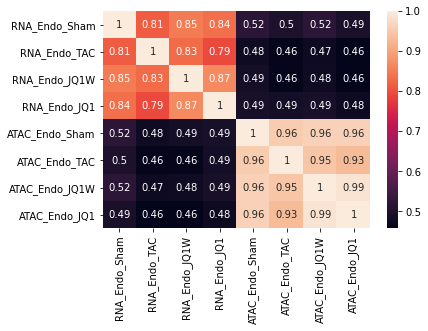

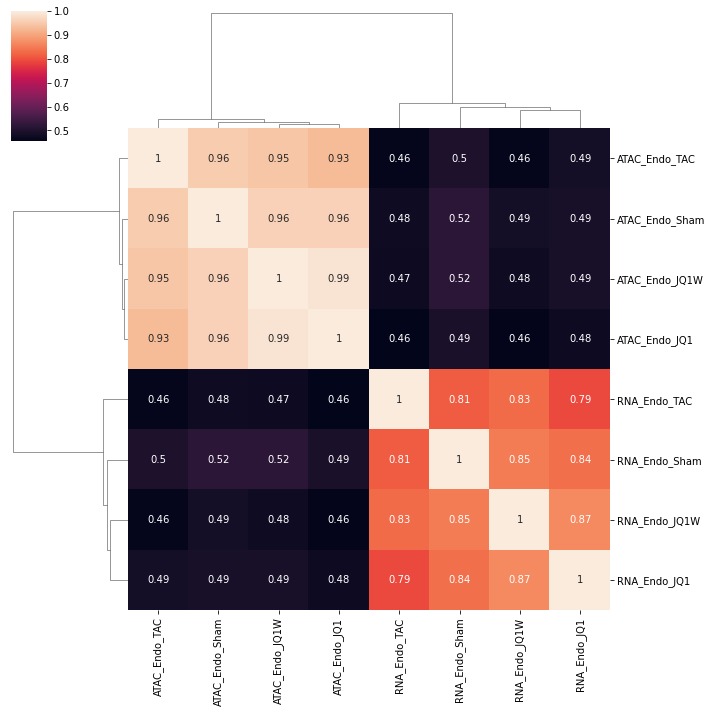

<Figure size 720x720 with 0 Axes>

In [4]:
#-----------------By cell type------------------
#merge samples for endothelial cells
mergeDict_Endo = {}
mergeDict_Endo['RNA_Endo_Sham'] = rnaDict['RNA_Endo_Sham']
mergeDict_Endo['RNA_Endo_TAC'] = rnaDict['RNA_Endo_TAC']
mergeDict_Endo['RNA_Endo_JQ1W'] = rnaDict['RNA_Endo_JQ1W']
mergeDict_Endo['RNA_Endo_JQ1'] = rnaDict['RNA_Endo_JQ1']
mergeDict_Endo['ATAC_Endo_Sham'] = atacDict['ATAC_Endo_Sham']
mergeDict_Endo['ATAC_Endo_TAC'] = atacDict['ATAC_Endo_TAC']
mergeDict_Endo['ATAC_Endo_JQ1W'] = atacDict['ATAC_Endo_JQ1W']
mergeDict_Endo['ATAC_Endo_JQ1'] = atacDict['ATAC_Endo_JQ1']


#create dataframe 
df_endo = pd.DataFrame(data=mergeDict_Endo)


#create correlation matrix using the pearson correlation coefficient
#correlation matrix for endothelial cells 
cell = "endo"
corr_matrix_endo = df_endo.corr(method = 'pearson')
heatmap = sns.heatmap(corr_matrix_endo, annot=True)
cluster = sns.clustermap(corr_matrix_endo, annot=True)


#saves figure for plot by cell type
plt.figure(figsize=(10,10))

#get figure and save figure
img_format = '.png'
exp = "RNAvsATAC"

figure2 = "heatmap"
filename2 = figure2 + '_' + exp + '_'+ cell + img_format
fig2 = heatmap.get_figure()
fig2.savefig('images/new_pipeline/all_reads_'+filename2,bbox_inches='tight')

figure3 = "clustermap"
filename3 = figure3 + '_' + exp + '_'+ cell + img_format
cluster.savefig('images/new_pipeline/all_reads_'+filename3)


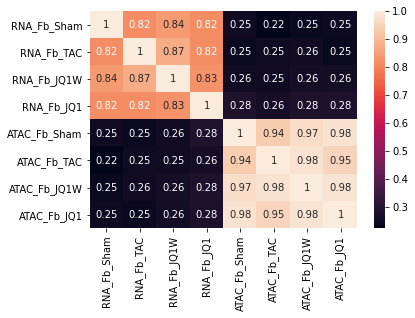

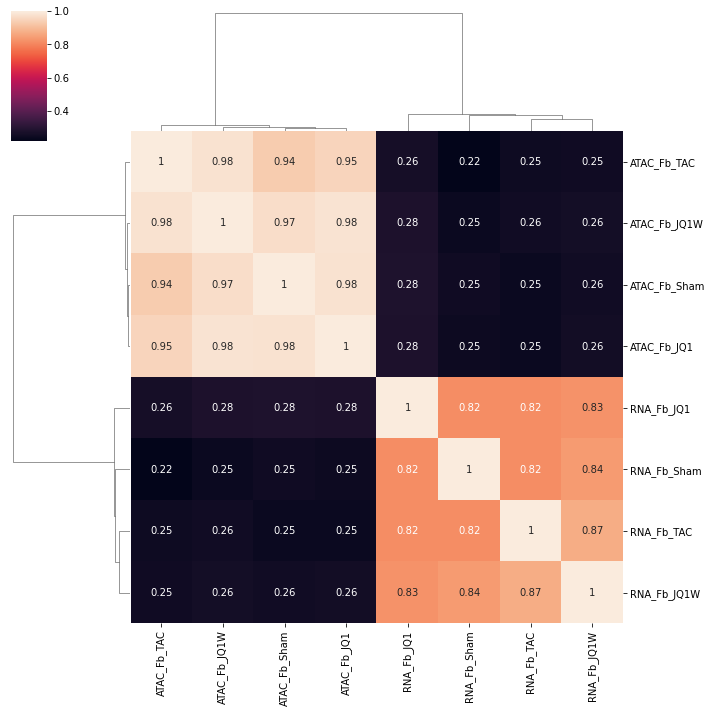

<Figure size 720x720 with 0 Axes>

In [8]:
#merge samples for fibroblast cells
mergeDict_Fb = {}
mergeDict_Fb['RNA_Fb_Sham'] = rnaDict['RNA_Fb_Sham']
mergeDict_Fb['RNA_Fb_TAC'] = rnaDict['RNA_Fb_TAC']
mergeDict_Fb['RNA_Fb_JQ1W'] = rnaDict['RNA_Fb_JQ1W']
mergeDict_Fb['RNA_Fb_JQ1'] = rnaDict['RNA_Fb_JQ1']
mergeDict_Fb['ATAC_Fb_Sham'] = atacDict['ATAC_Fb_Sham']
mergeDict_Fb['ATAC_Fb_TAC'] = atacDict['ATAC_Fb_TAC']
mergeDict_Fb['ATAC_Fb_JQ1W'] = atacDict['ATAC_Fb_JQ1W']
mergeDict_Fb['ATAC_Fb_JQ1'] = atacDict['ATAC_Fb_JQ1']

#create dataframe 
df_fb = pd.DataFrame(data=mergeDict_Fb)


# correlation matrix for fibroblast cells 
cell = "fb"
corr_matrix_fb = df_fb.corr(method = 'pearson')
heatmap = sns.heatmap(corr_matrix_fb, annot=True)
cluster = sns.clustermap(corr_matrix_fb, annot=True)

#saves figure for plot by cell type
plt.figure(figsize=(10,10))

#get figure and save figure
img_format = '.png'
exp = "RNAvsATAC"


figure2 = "heatmap"
filename2 = figure2 + '_' + exp + '_'+ cell + img_format
fig2 = heatmap.get_figure()
fig2.savefig('images/new_pipeline/all_reads_'+filename2,bbox_inches='tight')

figure3 = "clustermap"
filename3 = figure3 + '_' + exp + '_'+ cell + img_format
cluster.savefig('images/new_pipeline/all_reads_'+filename3)

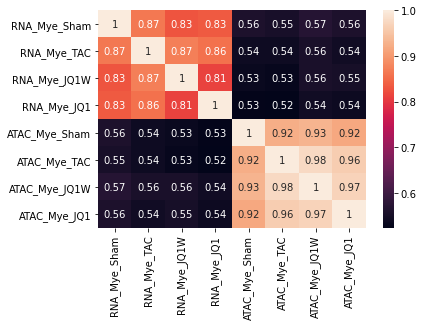

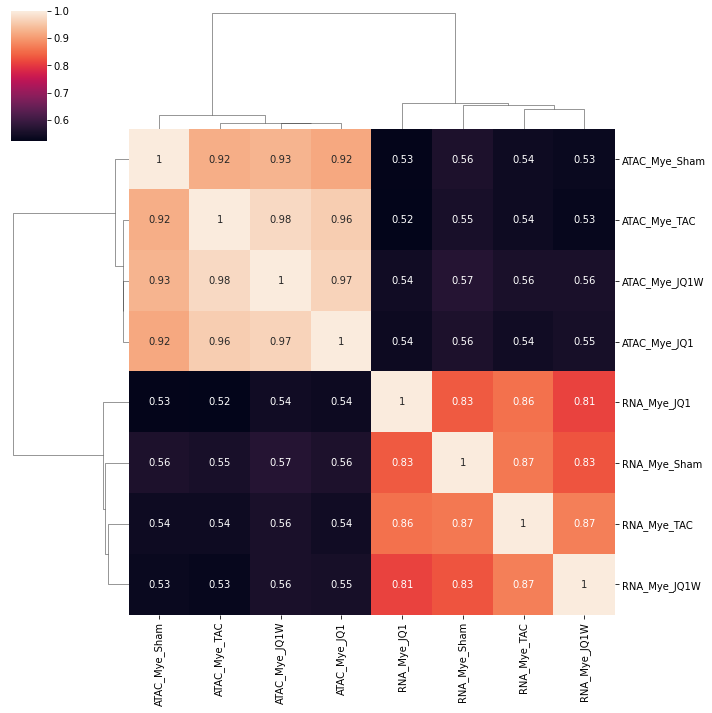

<Figure size 720x720 with 0 Axes>

In [9]:
#merge samples for myeloid cells 
mergeDict_Mye = {}
mergeDict_Mye['RNA_Mye_Sham'] = rnaDict['RNA_Mye_Sham']
mergeDict_Mye['RNA_Mye_TAC'] = rnaDict['RNA_Mye_TAC']
mergeDict_Mye['RNA_Mye_JQ1W'] = rnaDict['RNA_Mye_JQ1W']
mergeDict_Mye['RNA_Mye_JQ1'] = rnaDict['RNA_Mye_JQ1']
mergeDict_Mye['ATAC_Mye_Sham'] = atacDict['ATAC_Mye_Sham']
mergeDict_Mye['ATAC_Mye_TAC'] = atacDict['ATAC_Mye_TAC']
mergeDict_Mye['ATAC_Mye_JQ1W'] = atacDict['ATAC_Mye_JQ1W']
mergeDict_Mye['ATAC_Mye_JQ1'] = atacDict['ATAC_Mye_JQ1']

#create dataframe 
df_mye = pd.DataFrame(data=mergeDict_Mye)

# correlation matrix for myeloid cells
cell = "mye"
corr_matrix_mye = df_mye.corr(method = 'pearson')
heatmap = sns.heatmap(corr_matrix_mye, annot=True)
cluster = sns.clustermap(corr_matrix_mye, annot=True)

#saves figure for plot by cell type
plt.figure(figsize=(10,10))

#get figure and save figure
img_format = '.png'
exp = "RNAvsATAC"

figure2 = "heatmap"
filename2 = figure2 + '_' + exp + '_'+ cell + img_format
fig2 = heatmap.get_figure()
fig2.savefig('images/new_pipeline/all_reads_'+filename2,bbox_inches='tight')

figure3 = "clustermap"
filename3 = figure3 + '_' + exp + '_'+ cell + img_format
cluster.savefig('images/new_pipeline/all_reads'+filename3)

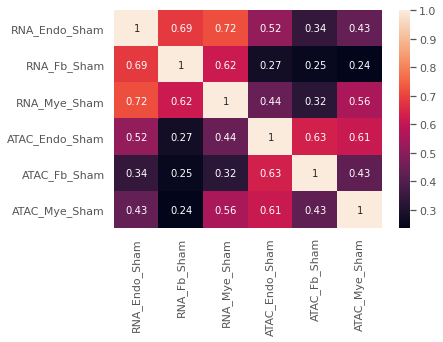

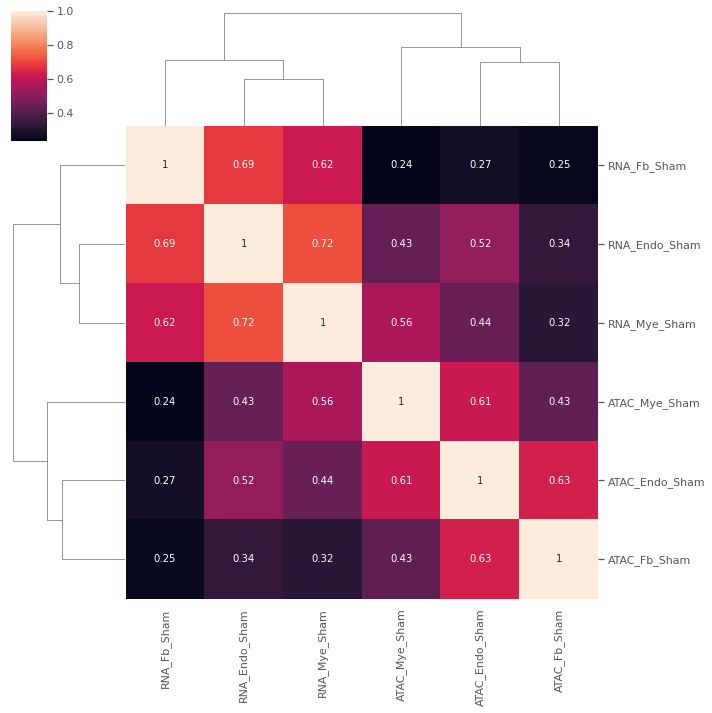

In [37]:

#-----------------By condition------------------
mergeDict_Sham= {}
mergeDict_TAC = {}
mergeDict_JQ1W = {}
mergeDict_JQ1 = {}

# #merge samples for Sham
mergeDict_Sham['RNA_Endo_Sham'] = rnaDict['RNA_Endo_Sham']
mergeDict_Sham['RNA_Fb_Sham'] = rnaDict['RNA_Fb_Sham']
mergeDict_Sham['RNA_Mye_Sham'] = rnaDict['RNA_Mye_Sham']
mergeDict_Sham['ATAC_Endo_Sham'] = atacDict['ATAC_Endo_Sham']
mergeDict_Sham['ATAC_Fb_Sham'] = atacDict['ATAC_Fb_Sham']
mergeDict_Sham['ATAC_Mye_Sham'] = atacDict['ATAC_Mye_Sham']

# #merge samples for TAC
mergeDict_TAC['RNA_Endo_TAC'] = rnaDict['RNA_Endo_TAC']
mergeDict_TAC['RNA_Fb_TAC'] = rnaDict['RNA_Fb_TAC']
mergeDict_TAC['RNA_Mye_TAC'] = rnaDict['RNA_Mye_TAC']
mergeDict_TAC['ATAC_Endo_TAC'] = atacDict['ATAC_Endo_TAC']
mergeDict_TAC['ATAC_Fb_TAC'] = atacDict['ATAC_Fb_TAC']
mergeDict_TAC['ATAC_Mye_TAC'] = atacDict['ATAC_Mye_TAC']

# #merge samples for JQ1W
mergeDict_JQ1W['RNA_Endo_JQ1W'] = rnaDict['RNA_Endo_JQ1W']
mergeDict_JQ1W['RNA_Fb_JQ1W'] = rnaDict['RNA_Fb_JQ1W']
mergeDict_JQ1W['RNA_Mye_JQ1W'] = rnaDict['RNA_Mye_JQ1W']
mergeDict_JQ1W['ATAC_Endo_JQ1W'] = atacDict['ATAC_Endo_JQ1W']
mergeDict_JQ1W['ATAC_Fb_JQ1W'] = atacDict['ATAC_Fb_JQ1W']
mergeDict_JQ1W['ATAC_Mye_JQ1W'] = atacDict['ATAC_Mye_JQ1W']

# #merge samples for JQ1
mergeDict_JQ1['RNA_Endo_JQ1'] = rnaDict['RNA_Endo_JQ1']
mergeDict_JQ1['RNA_Fb_JQ1'] = rnaDict['RNA_Fb_JQ1']
mergeDict_JQ1['RNA_Mye_JQ1'] = rnaDict['RNA_Mye_JQ1']
mergeDict_JQ1['ATAC_Endo_JQ1'] = atacDict['ATAC_Endo_JQ1']
mergeDict_JQ1['ATAC_Fb_JQ1'] = atacDict['ATAC_Fb_JQ1']
mergeDict_JQ1['ATAC_Mye_JQ1'] = atacDict['ATAC_Mye_JQ1']



# #create dataframe 
df_sham = pd.DataFrame(data=mergeDict_Sham)

df_tac = pd.DataFrame(data=mergeDict_TAC)

df_jq1w = pd.DataFrame(data=mergeDict_JQ1W)

df_jq1 = pd.DataFrame(data=mergeDict_JQ1)


condition = "Sham"
corr_matrix_sham = df_sham.corr(method = 'pearson')
heatmap = sns.heatmap(corr_matrix_sham, annot=True)
cluster = sns.clustermap(corr_matrix_sham, annot=True)


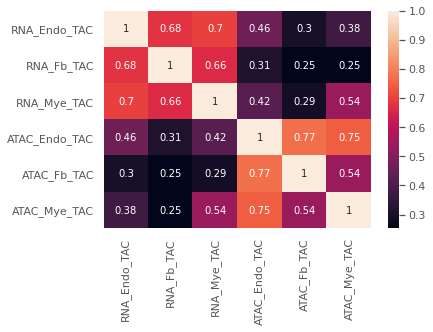

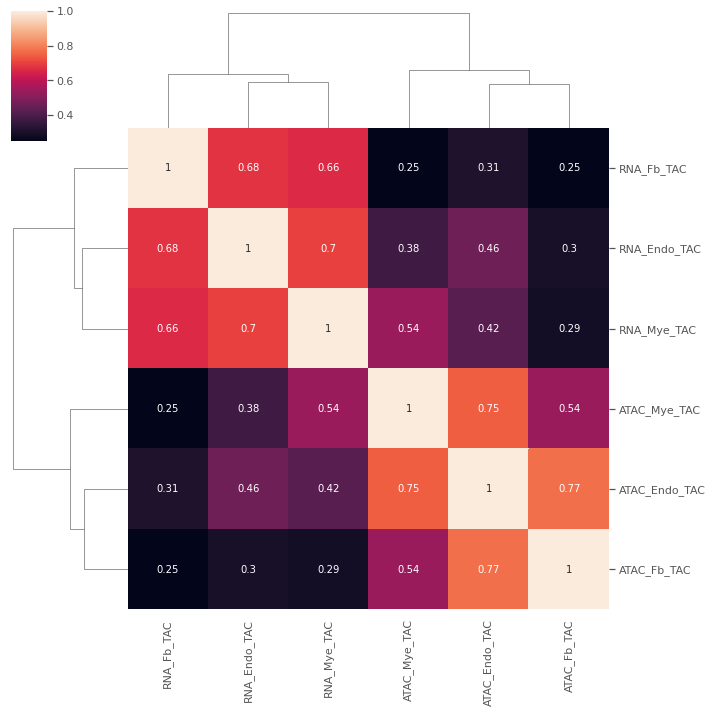

In [38]:
condition = "TAC"
corr_matrix_tac = df_tac.corr(method = 'pearson')
heatmap = sns.heatmap(corr_matrix_tac, annot=True)
cluster = sns.clustermap(corr_matrix_tac, annot=True)

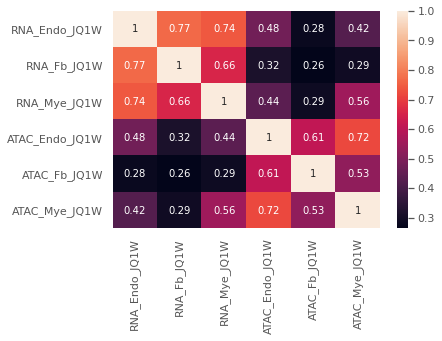

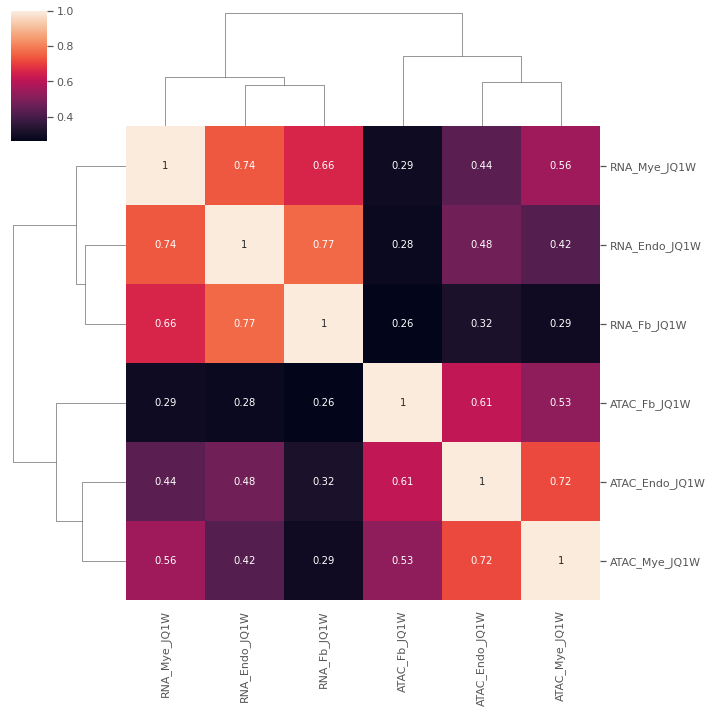

In [39]:
condition = "JQ1W"
corr_matrix_jq1w = df_jq1w.corr(method = 'pearson')
heatmap = sns.heatmap(corr_matrix_jq1w, annot=True)
cluster = sns.clustermap(corr_matrix_jq1w, annot=True)


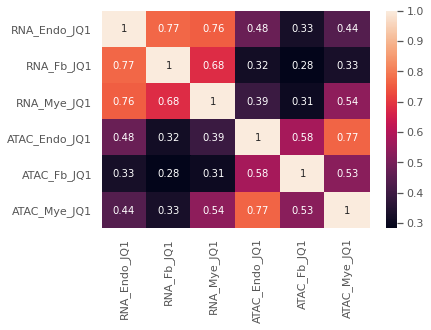

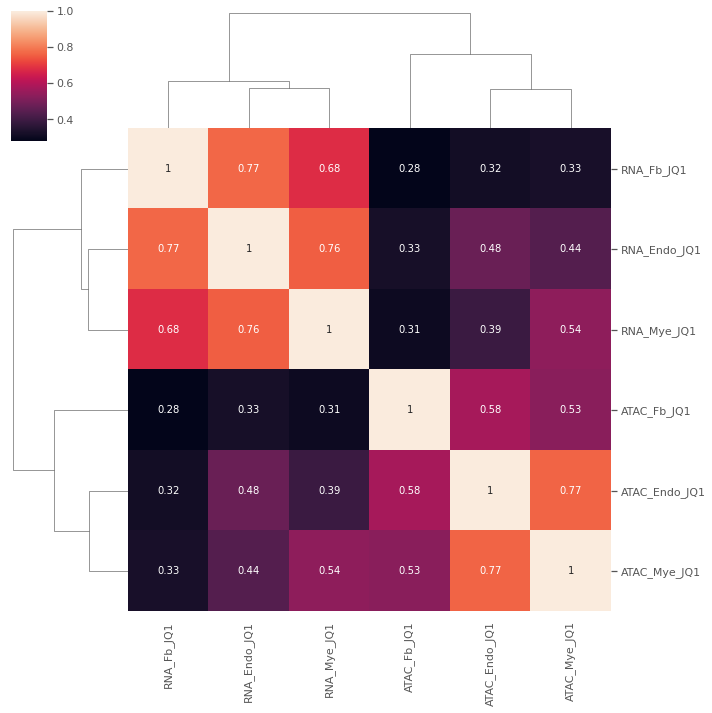

In [42]:
condition = "JQ1"
corr_matrix_jq1  = df_jq1 .corr(method = 'pearson')
heatmap = sns.heatmap(corr_matrix_jq1 , annot=True)
cluster = sns.clustermap(corr_matrix_jq1 , annot=True)

In [ ]:
#saves figure for plot by condition
plt.figure(figsize=(10,10))

#get figure and save figure
img_format = '.png'
exp = "RNAvsATAC"

figure2 = "heatmap"
filename2 = figure2 + '_' + exp + '_'+ condition + img_format
fig2 = heatmap.get_figure()
fig2.savefig('images/new_pipeline'+filename2,bbox_inches='tight')

figure3 = "clustermap"
filename3 = figure3 + '_' + exp + '_'+ condition + img_format
cluster.savefig('images/new_pipeline/'+filename3)

In [6]:
#----------------MAIN PROGRAM
rel_path = "../../../data/projects/morin/Counts/cellType_specific_counts/"
#store data in dictionary using key:sample, value: log(count+1) for CPM normalization
#and value: (log(count+1), length) for CPKM normalization


#list of filenames with counts 
samples_dir = "../../../data/projects/morin/cellType_specific_counts.txt"


rnaDict= run_ds_on_exp(samples_dir, rel_path, "RNA")
# print(rnaDict)

#normalize atac data
atacDict= run_ds_on_exp(samples_dir, rel_path, "ATAC")
# print(atacDict)

#merge conditions within celltypes for RNA
endo_rna = merge(rnaDict, 'Endo', 'RNA')
fib_rna = merge(rnaDict, 'Fb', 'RNA')
mye_rna = merge(rnaDict, 'Mye', 'RNA')
# print(mye_rna[290])
 

#merge conditions within celltypes for ATAC
endo_atac = merge(atacDict, 'Endo', 'ATAC')
fib_atac = merge(atacDict, 'Fb', 'ATAC')
mye_atac = merge(atacDict, 'Mye', 'ATAC')


#use RNA read counts on x axis 
cut_bins=[0,1,10,20,200]
cut_labels =["0", "1-10", "10-20", ">20"]



/pollard/home/smorin/miniconda3/envs/r-environment/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


RNA counts on x axis
     Pearson's Correlation Coefficient  counts_agg RNA Read Counts
0                            -0.912412   19.257081           10-20
1                            -0.959987   11.193824           10-20
2                             0.073904    3.889294            1-10
3                             0.892643   12.191391           10-20
4                             0.126175    7.711206            1-10
..                                 ...         ...             ...
465                           0.000000    0.000000               0
466                          -0.448593   18.131123           10-20
467                          -0.626096    7.372935            1-10
468                          -0.610557   13.266595           10-20
469                          -0.252455    2.317674            1-10

[470 rows x 3 columns]
10-20    216
>20      131
1-10     116
0          7
Name: RNA Read Counts, dtype: int64


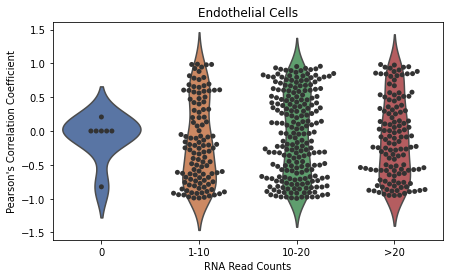

In [7]:
#------------------RNA reads vs Pearson's Correlation
cut_bins=[0,1,10,20,200]
cut_labels =["0", "1-10", "10-20", ">20"]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 4), sharex=True, sharey=True)

vp = counts_vs_corr("Endothelial Cells", endo_rna, endo_atac, axs, cut_bins, cut_labels, 'RNA Read Counts')


/pollard/home/smorin/miniconda3/envs/r-environment/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


RNA counts on x axis
     Pearson's Correlation Coefficient  counts_agg RNA Read Counts
0                            -0.315642   26.190736             >20
1                             0.412090   13.680435           10-20
2                            -0.276700    8.138476            1-10
3                             0.863951    9.184279            1-10
4                            -0.157353    7.344657            1-10
..                                 ...         ...             ...
465                          -0.300028    5.731971            1-10
466                           0.342483   16.752453           10-20
467                           0.023048   10.436995           10-20
468                           0.381584   15.032272           10-20
469                           0.929820    2.806296            1-10

[470 rows x 3 columns]
10-20    240
>20      118
1-10     106
0          6
Name: RNA Read Counts, dtype: int64


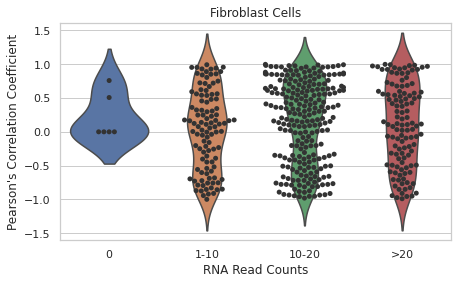

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 4), sharex=True, sharey=True)
vp = counts_vs_corr("Fibroblast Cells", fib_rna, fib_atac, axs, cut_bins, cut_labels, 'RNA Read Counts')

RNA counts on x axis
     Pearson's Correlation Coefficient  counts_agg RNA Read Counts
0                            -0.690373   16.548091           10-20
1                            -0.083281    6.452799            1-10
2                             0.459542    2.000382            1-10
3                            -0.540502    9.397894            1-10
4                             0.672986    2.682026            1-10
..                                 ...         ...             ...
465                          -0.451477    3.625421            1-10
466                           0.302845   17.922651           10-20
467                          -0.204112    5.209575            1-10
468                          -0.516266    8.925937            1-10
469                           0.000000    0.000000               0

[470 rows x 3 columns]
10-20    182
1-10     163
>20       98
0         27
Name: RNA Read Counts, dtype: int64


/pollard/home/smorin/miniconda3/envs/r-environment/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


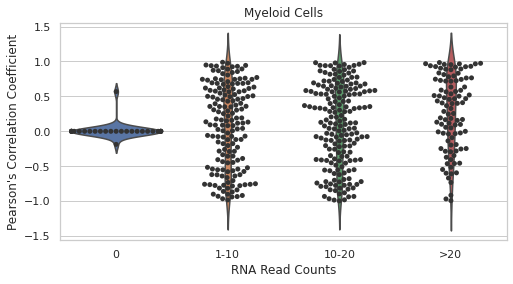

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharex=True, sharey=True)
vp = counts_vs_corr("Myeloid Cells", mye_rna, mye_atac, axs, cut_bins, cut_labels, 'RNA Read Counts')

In [16]:
#merge version 2 will order conditions according to experiment timeline
def merge_v2(expDict, cellType, exp):
    mergeList = []
    for sham,tac,jq1,jq1w in zip(expDict[exp+'_'+cellType+'_Sham'], 
                       expDict[exp+'_'+cellType+'_TAC'], 
                       expDict[exp+'_'+cellType+'_JQ1'], 
                       expDict[exp+'_'+cellType+'_JQ1W']):
        #for this model we want to use the conditions in the order they were administered (eg. JQ1 then JQ1W)
        mergeList.append([sham,tac,jq1,jq1w])
    return mergeList   

#For our labels, sometimes referred to as "targets," we're going to use 0 or 1
#from ATAC data
#generate an array of dynamic vs non dynamic
def create_binary_array(cellType_atac):
    binary_array = []
    for condition in cellType_atac:
        #order: sham, TAC, JQ1, JQ1W
        #       0      1    2    3
#         unstressed = condition[0] + condition[2]
#         stressed = condition[1] + condition[3]
        unstressed = condition[0]
        stressed = condition[1]
        if stressed > unstressed:
            binary_array.append(1) #dynamic enhancer
        else:
            binary_array.append(0) #non-dynamic enhancer
    return binary_array 

#merge conditions within celltypes for RNA
endo_rna = merge_v2(rnaDict, 'Endo', 'RNA')
fib_rna = merge_v2(rnaDict, 'Fb', 'RNA')
mye_rna = merge_v2(rnaDict, 'Mye', 'RNA')


#merge conditions within celltypes for ATAC
endo_atac = merge_v2(atacDict, 'Endo', 'ATAC')
fib_atac = merge_v2(atacDict, 'Fb', 'ATAC')
mye_atac = merge_v2(atacDict, 'Mye', 'ATAC')

In [17]:
wdir= '../../../data/projects/morin/'
inFile = open(wdir+'enhancers_log2foldchange.csv', 'r')
l2fchange = []
for line in inFile:
    splitLine = line.strip().split('\t')
    val = float(splitLine[3])
    l2fchange.append(val)

#change this depending on cell type we are analyzing
#the feature list being stored in a capital X variable
# sham ,tac, jq1, jq1w], #unstressed , stressed, unstressed, stressed
X= np.array(mye_rna) #accessing the features for celltype 
binary_array = create_binary_array(mye_atac) #ATAC data is used for labels only
y = binary_array
cell= 'Mye' #for accessing conditions in RNA dictionary
cellType = 'Myeloid' #for plot title


#make a data frame with : labels (dynamic vs non dynamic), sham, tac, jq1, jq1w)
table = {}
table['labels'] = binary_array
table['Sham'] = rnaDict['RNA_'+cell+'_Sham']
table['TAC'] = rnaDict['RNA_'+cell+'_TAC']
table['JQ1'] = rnaDict['RNA_'+cell+'_JQ1']
table['JQ1W'] = rnaDict['RNA_'+cell+'_JQ1W']
table['proseq_l2fc'] = l2fchange 

df = pd.DataFrame(data=table)
print(df)

X_train, X_test, y_train, y_test = train_test_split(df.drop('labels', axis=1), df.labels, test_size=0.3)

test_0 = ['Sham', 'TAC', 'JQ1', 'JQ1W', 'proseq_l2fc']
test_1 = ['Sham', 'JQ1W','proseq_l2fc']
test_2 = ['TAC', 'JQ1','proseq_l2fc']
test_3 = ['Sham', 'TAC','proseq_l2fc']
test_4 = ['JQ1', 'JQ1W','proseq_l2fc']
test_5 = ['Sham', 'TAC', 'JQ1','proseq_l2fc']
test_6 = ['Sham', 'TAC', 'JQ1W','proseq_l2fc']
test_7 = ['Sham', 'JQ1', 'JQ1W','proseq_l2fc']
test_8 = ['TAC', 'JQ1', 'JQ1W','proseq_l2fc']



features = [test_0, test_1, test_2, test_3, test_4, test_5, test_6, 
            test_7, test_8]
names = ['0', '1', '2', '3', '4', '5', '6', '7', '8']




#get the fractions of 1s and 0s - our preditiction has to be greater than this fraction 
#(means we are better than random), baseline is dynamic/total
count=0
for x in binary_array:
    if x == 1:
        count+=1
print("dynamic enhancers over total enhancers:", count/len(binary_array))

     labels      Sham       TAC       JQ1      JQ1W  proseq_l2fc
0         0  3.854234  3.698294  4.258182  4.737382     1.536834
1         1  2.343248  1.619470  2.490081  0.000000     0.986674
2         1  0.000000  0.648613  1.351769  0.000000     1.025116
3         1  2.448645  2.537463  2.712933  1.698852     0.122344
4         1  0.000000  0.000000  2.682026  0.000000    -0.167291
..      ...       ...       ...       ...       ...          ...
465       1  1.753664  1.871757  0.000000  0.000000     0.561887
466       1  4.619321  3.979481  4.948248  4.375600    -1.419198
467       1  1.068480  2.120010  0.000000  2.021085    -0.222549
468       1  2.526087  1.974035  3.079394  1.346421     0.716538
469       1  0.000000  0.000000  0.000000  0.000000     0.459669

[470 rows x 6 columns]
dynamic enhancers over total enhancers: 0.6468085106382979


[0.86897372 0.0551429 ]
(470, 2)


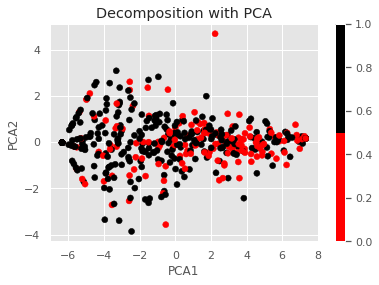

In [49]:
#run PCA to see if data is separable
import matplotlib.colors as mcolors

# print(len(np.clip(X, np.percentile(X, 5, axis=0), np.percentile(X, 95, axis=0))))

pca = PCA(n_components = 2)
X2D = pca.fit_transform(np.clip(X, np.percentile(X, 5, axis=0), np.percentile(X, 95, axis=0)))
print(pca.explained_variance_ratio_)
print(X2D.shape)

cmap = mcolors.ListedColormap(['red', '#000000'])
plt.scatter(X2D[:, 0], X2D[:, 1], c = y, cmap = cmap)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Decomposition with PCA')

plt.colorbar()

Text(0.5, 1.0, 'Decomposition with TSNE')

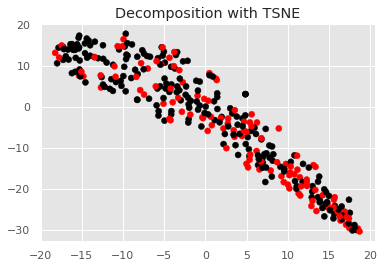

In [58]:
TSNE_model = TSNE(n_components = 2)
TSNE_data = TSNE_model.fit_transform(X_train)
TSNE_data.shape
dic = {}

plt.scatter(TSNE_data[:, 0], TSNE_data[:, 1], c = y_train, cmap = cmap)
plt.title('Decomposition with TSNE')
# plt.colorbar()

In [18]:
def select_model(features, model):
    '''This function trains and predicts a multiclass classification model and displays its score'''
    
    # Fit model
    clf = model.fit(X_train[features], y_train)
    
    # Make predictions
    y_predict = clf.predict(X_test[features])
    
    # Score model
    print('Accuracy: {}'.format(accuracy_score(y_test, y_predict)))
    print(classification_report(y_test, y_predict))
    
    # Create dataframe of scored model
    global dataframe
    dataframe = pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)).transpose()
    
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(y_test, y_predict, classes=df.labels,
                          title='Confusion matrix, without normalization')
    
    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, y_predict, classes=df.labels, normalize=True,
                          title='Normalized confusion matrix')

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                         subplot=0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = df.labels.unique()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # And label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [19]:
# Create pipeline
pipeline = make_pipeline(SVC(random_state=10))

# Select hyperparameters
hyperparameters = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'svc__kernel': ['rbf', 'linear'],
                  'svc__gamma': [0.001, 0.01, 0.1, 1]}

# For loop to select best set of features, hyperparameters
best_score = 0
best_feature = str()
best_param = str()
# Loop
for feature, name in zip(features, names): # Go into feature
    clf = GridSearchCV(pipeline, hyperparameters, cv=5) # Check hyperparameters
    clf.fit(X_train[feature], y_train)
    if clf.best_score_ > best_score: # If better than others, save
        best_score = clf.best_score_
        best_feature = name
        best_param = clf.best_params_
        
print('best feature:', best_feature)
print('best parameters: ', best_param)
print('best score: ', best_score)

best feature: 1
best parameters:  {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
best score:  0.6687179487179487


Accuracy: 0.6453900709219859
              precision    recall  f1-score   support

           0       0.67      0.08      0.14        52
           1       0.64      0.98      0.78        89

    accuracy                           0.65       141
   macro avg       0.66      0.53      0.46       141
weighted avg       0.65      0.65      0.54       141



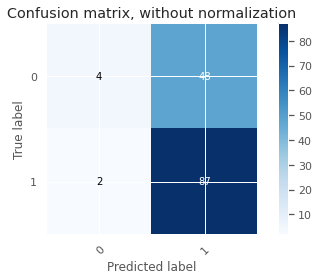

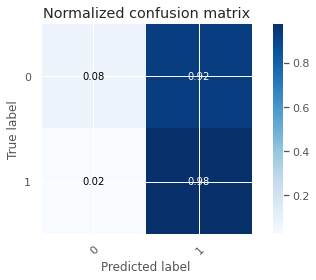

In [20]:
# Test model using the parameters from gridsearchCV
select_model(test_1, SVC(random_state=10, 
          C=10, 
          kernel='rbf', 
          gamma=0.1))
# Rename dataframe
svc = dataframe

In [22]:

# Create pipeline
pipeline = make_pipeline(KNeighborsClassifier())

# Select hyperparameters
hyperparameters = {'kneighborsclassifier__n_neighbors': np.arange(1,10)}

# For loop to select best set of features, hyperparameters
best_score = 0
best_feature = str()
best_param = str()
# Loop
for feature, name in zip(features, names): # Go into feature
    clf = GridSearchCV(pipeline, hyperparameters, cv=5) # Check hyperparameters
    clf.fit(X_train[feature], y_train)
    if clf.best_score_ > best_score: # If better than others, save
        best_score = clf.best_score_
        best_feature = name
        best_param = clf.best_params_
        
print('best feature:', best_feature)
print('best parameters: ', best_param)
print('best score: ', best_score)

best feature: 7
best parameters:  {'kneighborsclassifier__n_neighbors': 9}
best score:  0.6748717948717949


Accuracy: 0.6453900709219859
              precision    recall  f1-score   support

           0       0.55      0.23      0.32        52
           1       0.66      0.89      0.76        89

    accuracy                           0.65       141
   macro avg       0.60      0.56      0.54       141
weighted avg       0.62      0.65      0.60       141



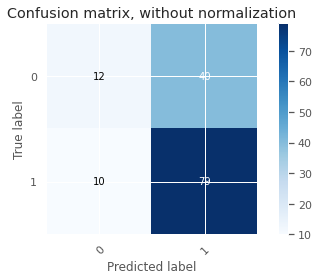

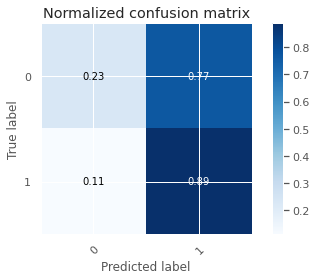

In [24]:
# Test model using the parameters from gridsearchCV
select_model(test_7, KNeighborsClassifier(n_neighbors =9))
# Rename dataframe
svc = dataframe

In [25]:
# Create pipeline
pipeline = make_pipeline(RandomForestClassifier(random_state=10))

# Select hyperparameters
hyperparameters = {'randomforestclassifier__max_features': ['sqrt', 'log2', None],
                  'randomforestclassifier__max_depth': [None, 5, 3, 1],
                  'randomforestclassifier__n_estimators': [10, 25, 50, 75, 100]}

# For loop to select best set of features, hyperparameters
best_score = 0
best_feature = str()
best_param = str()
# Loop
for feature, name in zip(features, names): # Go into feature
    clf = GridSearchCV(pipeline, hyperparameters, cv=5) # Check hyperparameters
    clf.fit(X_train[feature], y_train)
    if clf.best_score_ > best_score: # If better than others, save
        best_score = clf.best_score_
        best_feature = name
        best_param = clf.best_params_
        
print('best feature:', best_feature)
print('best parameters: ', best_param)
print('best score: ', best_score)

best feature: 4
best parameters:  {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
best score:  0.6567832167832168


Accuracy: 0.6382978723404256
              precision    recall  f1-score   support

           0       0.52      0.25      0.34        52
           1       0.66      0.87      0.75        89

    accuracy                           0.64       141
   macro avg       0.59      0.56      0.54       141
weighted avg       0.61      0.64      0.60       141



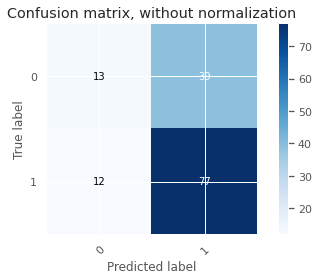

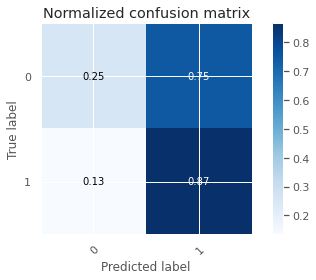

In [29]:
# Test model using the parameters from gridsearchCV
select_model(test_4, RandomForestClassifier(random_state=10, 
          max_depth = 5, 
          max_features= 'sqrt', 
          n_estimators= 50))
# Rename dataframe
svc = dataframe